In [ ]:
#1
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

df = pd.read_csv("ZIONO_weekly_return_volatility.csv")
df.label = df.label.fillna(method='ffill')
df_21 = df[df.Year==2021]
df_22 = df[df.Year==2022]

df_22.head(10)


df_22.head() # mean


,Year,Week_Number,mean_return,volatility,label
54,2022,1,-0.2012,0.842329,red
55,2022,2,0.1002,0.604448,green
56,2022,3,0.1525,0.591757,green
57,2022,4,-0.3576,1.847664,red
58,2022,5,-0.1206,0.762250,red


In [ ]:
# 1 , construct df_train
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats

x_21 = df_21[["mean_return"]].values
le = LabelEncoder()
y_21 = le.fit_transform(df_21["label"].values)
y_22 = le.transform(df_22["label"].values)


df_train = pd.DataFrame({'mean_return': df_21["mean_return"].values, 'volatility':df_21['volatility'].values, 'y': y_21})
df_train.head()

,mean_return,volatility,y
0,-0.2586,0.729467,0
1,0.0776,0.787634,1
2,0.9710,2.437100,0
3,-0.5042,1.114784,1
4,0.1458,1.217830,0


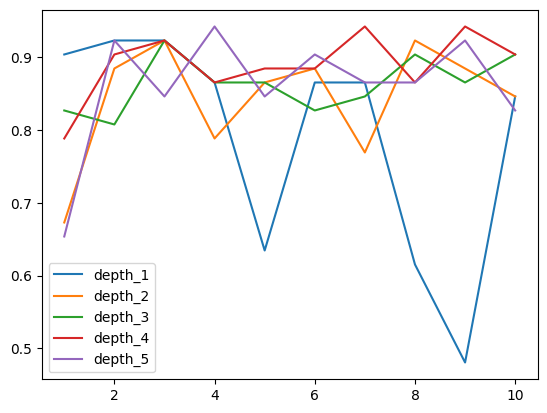

,depth_1,depth_2,depth_3,depth_4,depth_5
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.792308,0.844231,0.863462,0.890385,0.859615
std,0.155916,0.078744,0.037869,0.045373,0.082116
min,0.480769,0.673077,0.807692,0.788462,0.653846
25%,0.687500,0.802885,0.831731,0.870192,0.846154
50%,0.865385,0.875000,0.865385,0.894231,0.865385
75%,0.894231,0.884615,0.894231,0.918269,0.918269
max,0.923077,0.923077,0.923077,0.942308,0.942308


In [ ]:
from sklearn . ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X = df_train[["mean_return", "volatility"]].values
Y = df_train.y.values

df = pd.DataFrame()
for d in range(1, 6):
    dic = {}
    for N in range(1, 11):
        clf = RandomForestClassifier ( n_estimators =N , max_depth =d ,criterion ='entropy')
        clf = clf .fit(X,Y)

        new_x = df_22[["mean_return", "volatility"]].values
        predicted = clf.predict(new_x)

        # 1 accuracy
        dic[N] = np.mean(predicted == y_22)
    df[f"depth_{d}"] = pd.Series(dic)
    
df.plot()
plt.show()
df.describe()

# 1 we can see the best depth=5, N = 4

In [ ]:
# 2
# test N = 4 depth=5
N = 4
d = 5
clf = RandomForestClassifier ( n_estimators =N , max_depth =d ,criterion ='entropy')
clf = clf .fit(X,Y)

new_x = df_22[["mean_return", "volatility"]].values
predicted = clf.predict(new_x)

# 1 accuracy
confusion_matrix(y_22, predicted)

array([[26,  1],
       [ 2, 23]], dtype=int64)

In [ ]:
# 3. rate
tn, fp, fn, tp = confusion_matrix(y_22, predicted).ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
tpr, tnr

(0.92, 0.9629629629629629)

In [ ]:
# 4 compare
# df
df_detail = pd.read_csv("ZIONO_weekly_return_detailed.csv")
df_detail.head(22)


df_detail_22 = df_detail[["Close", "Week_Number", "Year"]]
df_detail_22 = df_detail_22[df_detail_22.Year == 2022]
df_22_week = df_detail_22.groupby("Week_Number").last()
df_22_week.head()

,Close,Year
Week_Number,,
1,26.290001,2022
2,26.420000,2022
3,26.580000,2022
4,26.090000,2022
5,25.930000,2022


In [ ]:
# buy_and_hold
buy_hold_add = df_22_week.Close.values[-1] - df_22_week.Close.values[0]
buy_hold_add

-0.9200000762939453

In [ ]:
def get_benefit_my_strategy(pred_labels, close_prices):
    money = 100
    hold_share = False
    for i in range(len(pred_labels)): # 1 red
#         print(pred_labels[i], close_prices[i])
        
        if (pred_labels[i] == 1): # red---> if not owning, buy one
            if hold_share:
                pass
            else:
                hold_share = True
                money -= close_prices[i]
        else:           # green ---->if owning, sell it
            if hold_share:
                hold_share = False
                money += close_prices[i]
                
        
    share_value = close_prices[-1] if hold_share else 0
    return money + share_value - 100
                    

get_benefit_my_strategy( predicted.tolist(), df_22_week.Close.values.tolist())

1.7399978637695312

In [ ]:
# we can see it is much better than buy-and-hold